# ASCAT obs_var in-situ plotter

Replicates the CYGNSS in-situ overlay plots for Err_6.4%, Err_9.0%, CNTL.


In [1]:
from scipy.stats import t
import numpy as np
import pandas as pd
import xarray as xr
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.spatial import cKDTree
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import get_cmap


# repo utilities

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
sys.path.append(str(repo_root / 'projects' / 'matlab2python' / 'shared' / 'python'))
sys.path.append('../util/shared/python/')

from geospatial_plotting import plot_region, REGION_BOUNDS, load_ease_grid, build_ease_grid_mapping
from read_GEOSldas import read_tilecoord

# Plot look
palette = {"SCAN": "#0072B2", "USCRN": "#E69F00", "SMAP Core": "#009E73"}
markers = {"SCAN": "o", "USCRN": "s", "SMAP Core": "^"}
title_fs = 15
label_fs = 11
tick_fs  = 10
legend_fs = 12
dot_size = 70
capsize = 2

In [2]:
DATA_DIR = Path('/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/ASCAT_obs_var')

experiments = [
    {"prefix": "LS_OLv8_M36", "label": "CNTL"},
    {"prefix": "LS_DAv8_M36_obs_var_9", "label": "Err_9.0%"},
    {"prefix": "LS_DAv8_M36_obs_var_64", "label": "Err_6.4%"},
]

networks = [
    ("_SCAN_SM_1d_c1234smv_5yr", "SCAN"),
    ("_USCRN_SM_1d_c1234smv_5yr", "USCRN"),
    ("_CalVal_M33_SM_1d__5yr", "SMAP Core"),
]

panel_info_means = [
    ("R",      r"$R$ (-)",                (0.50, 0.90)),
    ("anomR",  r"anomR (-)",              (0.50, 0.90)),
    ("ubRMSE", r"ubRMSD ($m^3 m^{-3}$)",  (0.015, 0.060)),
]

panel_info_delta = [
    ("R",      r"Δ$R$ (EXP − CNTL)",                      (-0.02, 0.08)),
    ("anomR",  r"ΔanomR (EXP − CNTL)",                    (-0.02, 0.08)),
    ("ubRMSE", r"ΔubRMSD (CNTL − EXP) $m^3 m^{-3}$",     (-0.002, 0.008)),
]


In [3]:
def reduce_metric_means_ci(arr, lo, up):
    mean = np.nanmean(arr, axis=0)
    n = np.sum(~np.isnan(arr), axis=0)
    denom = np.sqrt(np.maximum(n, 1))
    ci_lo = np.nanmean(lo, axis=0) / denom
    ci_up = np.nanmean(up, axis=0) / denom
    ci_mag = np.vstack([np.abs(ci_lo), np.abs(ci_up)])
    return mean, ci_mag, n

def paired_delta_stats(arr_cntl, arr_exp, up_is_better=True, alpha=0.05):
    sign = +1 if up_is_better else -1
    D = sign * (arr_exp - arr_cntl)
    mask = (~np.isnan(arr_cntl)) & (~np.isnan(arr_exp))
    depth = arr_cntl.shape[1]
    mean_delta = np.full(depth, np.nan)
    ci_half = np.full(depth, 0.0)
    n_eff = np.zeros(depth, dtype=int)
    for d in range(depth):
        m = mask[:, d]
        if not np.any(m):
            continue
        di = D[m, d]
        n = di.size
        n_eff[d] = n
        dbar = np.nanmean(di)
        sd = np.nanstd(di, ddof=1) if n > 1 else 0.0
        se = sd / np.sqrt(max(n, 1))
        k = t.ppf(1 - alpha/2, df=max(n-1, 1))
        mean_delta[d] = dbar
        ci_half[d] = k * se
    return mean_delta, ci_half, n_eff


def plot_overlay(means_dict, cis_dict, Ns_dict, panel_info, outfile,
                 expt_idx=None, x_tick_labels=None):
    num_networks = len(networks)
    all_idx = np.arange(len(experiments))
    if expt_idx is None:
        expt_idx = all_idx
    expt_idx = np.asarray(expt_idx)
    if x_tick_labels is None:
        x_tick_labels = [experiments[i]['label'] for i in expt_idx]

    fig = plt.figure(figsize=(12.5, 7.6), constrained_layout=True)
    mosaic = [
        ["legend", "legend", "legend"],
        ["s0", "s1", "s2"],
        ["r0", "r1", "r2"],
    ]
    axs = fig.subplot_mosaic(mosaic, gridspec_kw={"height_ratios": [0.14, 1.0, 1.0]})
    labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
    label_keys = ["s0", "s1", "s2", "r0", "r1", "r2"]
    for lab, key in zip(labels, label_keys):
        axs[key].text(0.02, 0.97, lab, transform=axs[key].transAxes,
                      fontsize=12, fontweight="normal", va="top", ha="left")
    ax_leg = axs["legend"]; ax_leg.axis("off")

    x = np.arange(len(expt_idx))
    offsets = np.linspace(-0.18, 0.18, num_networks)

    for col, (metric_key, ylab, ylim) in enumerate(panel_info):
        for depth in [0, 1]:
            ax = axs[("s" if depth == 0 else "r") + str(col)]
            ax.grid(axis="y", color="lightgrey", zorder=0)
            ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.7, zorder=1)
            ax.set_axisbelow(True)

            for ni, (_, nlabel) in enumerate(networks):
                y  = means_dict[metric_key][ni, depth, expt_idx]
                xpos = x + offsets[ni]

                ci = np.asarray(cis_dict[metric_key][ni, :, depth, expt_idx], dtype=float)
                if ci.ndim == 0:
                    val = float(ci); ci = np.array([[val],[val]])
                elif ci.ndim == 1:
                    ci = np.vstack([ci, ci])
                elif ci.ndim == 2 and ci.shape[0] != 2:
                    ci = ci.T

                ax.scatter(xpos, y, s=dot_size, marker=markers[nlabel],
                           color=palette[nlabel], edgecolor="none", zorder=3,
                           label=nlabel if (depth==0 and col==0) else None)
                ax.errorbar(xpos, y, yerr=ci, fmt="none", ecolor="gray",
                            elinewidth=1.0, capsize=capsize, zorder=2)

            ax.set_ylim(*ylim)
            if depth == 1:
                ax.set_xticks(x, x_tick_labels, fontsize=tick_fs)
            else:
                ax.set_xticks(x, [""] * len(x_tick_labels))

            layer = "Surface" if depth == 0 else "Rootzone"
            ax.set_ylabel(f"{layer} {ylab}", fontsize=label_fs)

            ntext = " | ".join(
                f"{networks[ni][1]} n={int(Ns_dict[metric_key][ni, depth, 0])}"
                for ni in range(num_networks)
            )
            ax.set_title(ntext, fontsize=10)

    handles, labels = axs["s0"].get_legend_handles_labels()
    if handles:
        ax_leg.legend(handles, labels, loc="center", ncols=len(labels),
                      fontsize=legend_fs, frameon=False, handletextpad=0.6, borderaxespad=0.0)

    fig.savefig(outfile, dpi=300, bbox_inches="tight", pad_inches=0.04)
    plt.show()


In [4]:
metrics = ["R", "anomR", "ubRMSE"]
num_expts = len(experiments)
num_networks = len(networks)

store_R = [[None]*num_expts for _ in range(num_networks)]
store_anomR = [[None]*num_expts for _ in range(num_networks)]
store_ub = [[None]*num_expts for _ in range(num_networks)]

means_raw = {m: np.full((num_networks, 2, num_expts), np.nan) for m in metrics}
cis_raw   = {m: np.full((num_networks, 2, 2, num_expts), np.nan) for m in metrics}
Ns_raw    = {m: np.zeros((num_networks, 2, num_expts), dtype=int) for m in metrics}

for ni, (tag, nlabel) in enumerate(networks):
    for ei, ex in enumerate(experiments):
        stats_path = DATA_DIR / f"{ex['prefix']}{tag}_stats.mat"
        if not stats_path.exists():
            stats_path = DATA_DIR / f"{ex['prefix']}{tag}_stats.mat"  # keep identical, but allow edit if needed
        mat = sio.loadmat(stats_path, squeeze_me=False)
        R       = np.asarray(mat["R"])
        RLO     = np.asarray(mat["RLO"])
        RUP     = np.asarray(mat["RUP"])
        anomR   = np.asarray(mat["anomR"])
        anomRLO = np.asarray(mat["anomRLO"])
        anomRUP = np.asarray(mat["anomRUP"])
        ub      = np.asarray(mat["ubRMSE"])
        ubLO    = np.asarray(mat["ubRMSELO"])
        ubUP    = np.asarray(mat["ubRMSEUP"])

        store_R[ni][ei]     = R
        store_anomR[ni][ei] = anomR
        store_ub[ni][ei]    = ub

        for key, arrs in {
            "R":      (R, RLO, RUP),
            "anomR":  (anomR, anomRLO, anomRUP),
            "ubRMSE": (ub, ubLO, ubUP),
        }.items():
            m, ci2, n = reduce_metric_means_ci(*arrs)
            means_raw[key][ni, :, ei] = m
            cis_raw[key][ni, :, :, ei] = ci2
            Ns_raw[key][ni, :, ei] = n


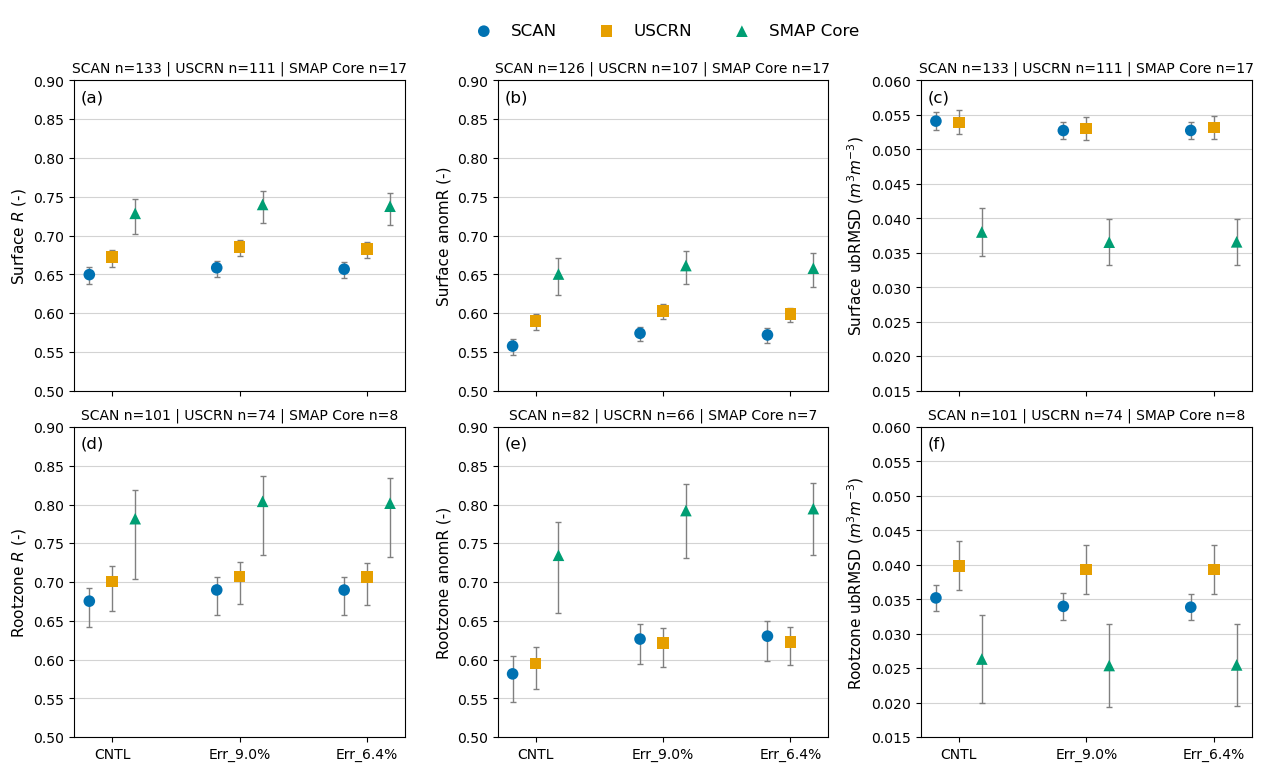

In [5]:
plot_overlay(means_raw, cis_raw, Ns_raw, panel_info_means,
             'obs_var_insitu_raw_overlay.png')


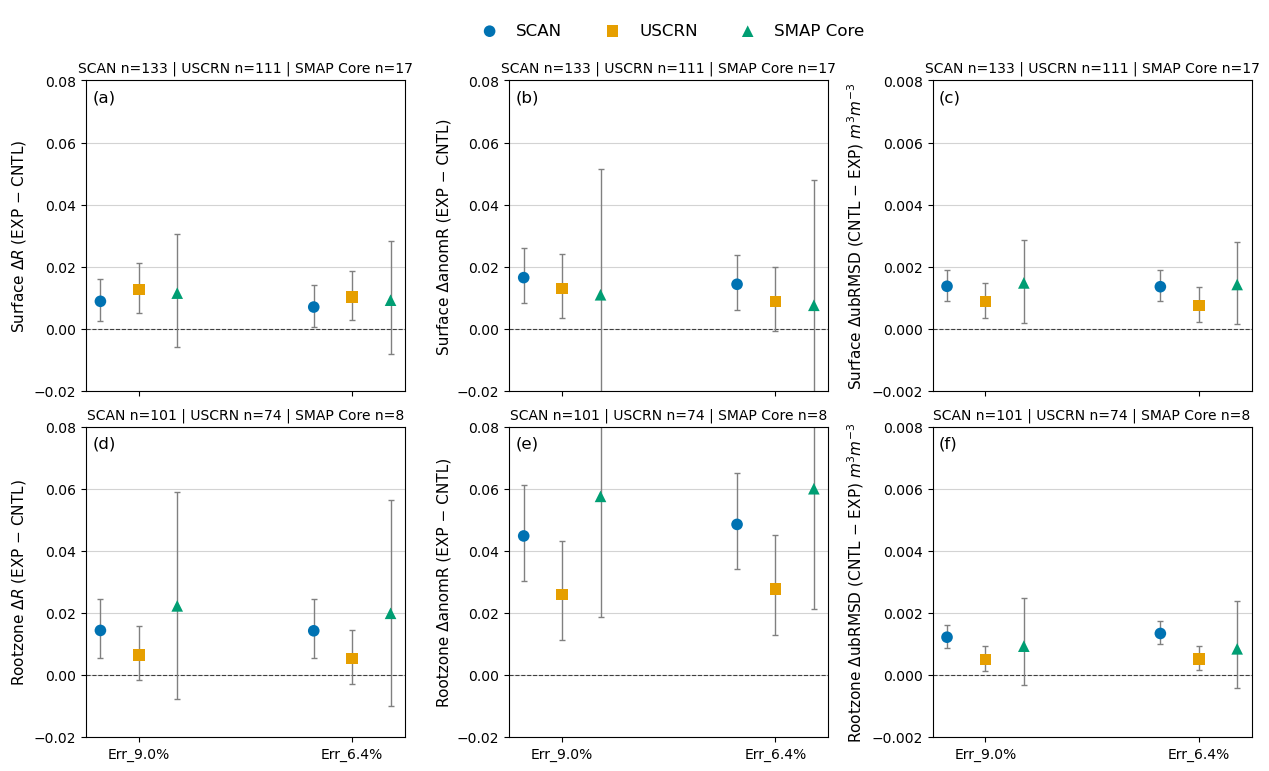

In [6]:
delta_means = {m: np.zeros_like(means_raw[m]) for m in metrics}
delta_cis   = {m: np.zeros_like(cis_raw[m])   for m in metrics}
Ns_delta    = {m: np.zeros_like(Ns_raw[m])    for m in metrics}

for ni in range(num_networks):
    R_cntl     = store_R[ni][0]
    anomR_cntl = store_anomR[ni][0]
    ub_cntl    = store_ub[ni][0]
    for key in metrics:
        delta_means[key][ni, :, 0] = 0.0
        delta_cis[key][ni, :, :, 0] = 0.0
        Ns_delta[key][ni, :, 0] = np.sum(~np.isnan(store_R[ni][0]), axis=0)
    for ei in range(1, num_expts):
        md, hw, n = paired_delta_stats(R_cntl, store_R[ni][ei], up_is_better=True)
        delta_means["R"][ni, :, ei] = md
        delta_cis["R"][ni, 0, :, ei] = hw; delta_cis["R"][ni, 1, :, ei] = hw
        Ns_delta["R"][ni, :, ei] = n

        md, hw, n = paired_delta_stats(anomR_cntl, store_anomR[ni][ei], up_is_better=True)
        delta_means["anomR"][ni, :, ei] = md
        delta_cis["anomR"][ni, 0, :, ei] = hw; delta_cis["anomR"][ni, 1, :, ei] = hw
        Ns_delta["anomR"][ni, :, ei] = n

        md, hw, n = paired_delta_stats(ub_cntl, store_ub[ni][ei], up_is_better=False)
        delta_means["ubRMSE"][ni, :, ei] = md
        delta_cis["ubRMSE"][ni, 0, :, ei] = hw; delta_cis["ubRMSE"][ni, 1, :, ei] = hw
        Ns_delta["ubRMSE"][ni, :, ei] = n

plot_overlay(
    delta_means, delta_cis, Ns_delta, panel_info_delta,
    'obs_var_insitu_delta_overlay.png',
    expt_idx=[1,2],
    x_tick_labels=[experiments[i]['label'] for i in [1,2]]
)


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_82949/3865677683.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_82949/3865677683.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  get_cmap('RdBu_r', len(levels_anomR)-1),
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_82949/3865677683.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` ins

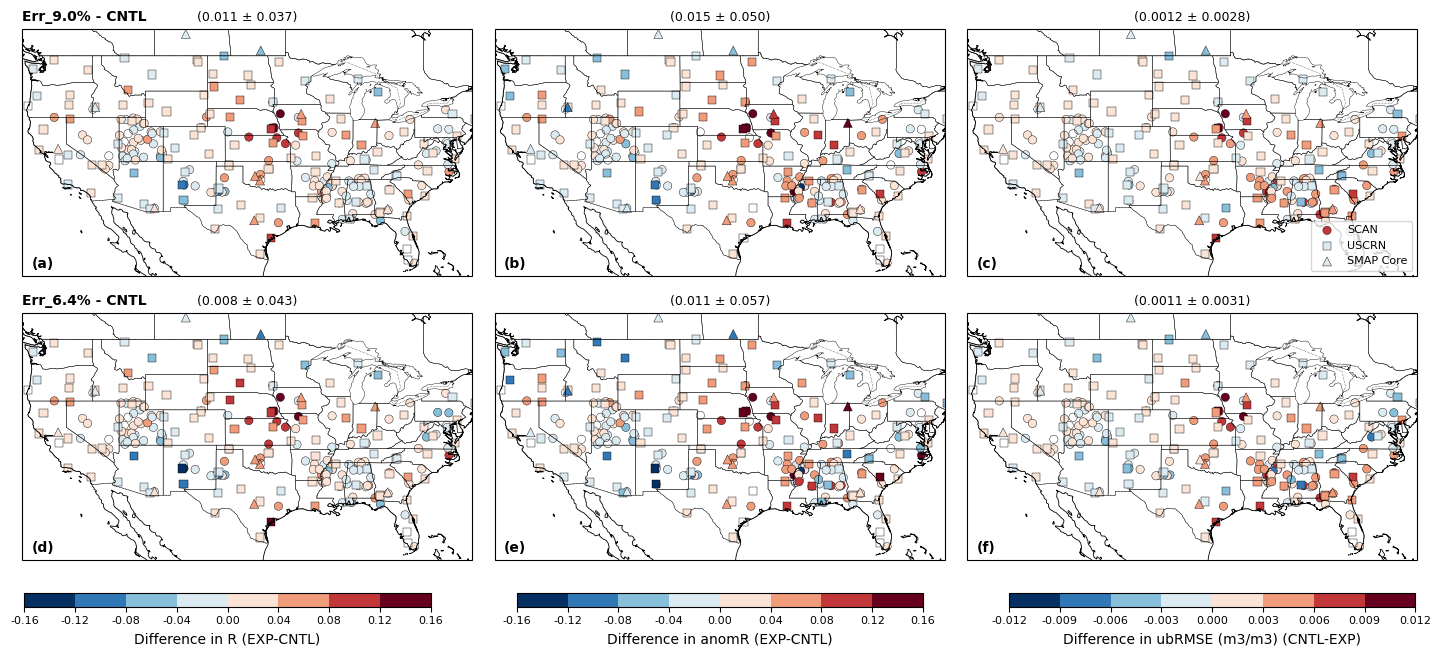

In [14]:
# Combined 3x3 overlay for all networks (SCAN, USCRN, SMAP Core) with SMAP on top
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap

# Build overlay order using existing networks (use 5yr tags), SMAP drawn last
order_labels = ['SCAN', 'USCRN', 'SMAP Core']
markers = {'SCAN': ('o', 36), 'USCRN': ('s', 34), 'SMAP Core': ('^', 42)}
overlay_networks = []
for lbl in order_labels:
    for tag, nlabel in networks:
        if nlabel == lbl:
            marker, size = markers.get(lbl, ('o', 36))
            overlay_networks.append((tag, nlabel, marker, size))
            break

levels_R = np.linspace(-0.16, 0.16, 9)
levels_anomR = np.linspace(-0.16, 0.16, 9)
levels_ub = np.linspace(-0.012, 0.012, 9)
cmaps = [get_cmap('RdBu_r', len(levels_R)-1),
         get_cmap('RdBu_r', len(levels_anomR)-1),
         get_cmap('RdBu_r',   len(levels_ub)-1)]
levels_list = [levels_R, levels_anomR, levels_ub]
titles_col = ['Difference in R (EXP-CNTL)', 'Difference in anomR (EXP-CNTL)', 'Difference in ubRMSE (m3/m3) (CNTL-EXP)']
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
rows = [
    (f"{experiments[1]['label']} - CNTL", 1),
    (f"{experiments[2]['label']} - CNTL", 2),
]

# Determine control prefix
if 'experiment_names' in globals():
    control_prefix = experiment_names[0]
elif 'experiments' in globals():
    control_prefix = experiments[0]['prefix']
else:
    raise NameError('experiment_names/experiments not defined; run setup cells first')

# Precompute arrays and lat/lon per network
overlay_data = {}
for tag, nlabel, _, _ in overlay_networks:
    try:
        nidx = next(i for i, (t, _) in enumerate(networks) if t == tag)
    except StopIteration:
        raise ValueError(f'Network tag {tag} not found in networks={networks}')
    overlay_data[tag] = {
        'R': np.stack(store_R[nidx], axis=-1),
        'anomR': np.stack(store_anomR[nidx], axis=-1),
        'ubRMSE': np.stack(store_ub[nidx], axis=-1),
    }
    base_dir = BASE_DIR if 'BASE_DIR' in globals() else DATA_DIR
    raw_path = base_dir / f"{control_prefix}{tag}_raw_timeseries.mat"
    mat_raw = sio.loadmat(raw_path, squeeze_me=False)
    overlay_data[tag]['lat'] = mat_raw['INSITU_lat'].flatten()
    overlay_data[tag]['lon'] = mat_raw['INSITU_lon'].flatten()

fig, axes = plt.subplots(2, 3, figsize=(18, 7), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.reshape(2, 3)
lab_idx = 0
legend_handles = None
legend_labels = None

# Store all data for statistics calculation
panel_stats = {}

for r_idx, (row_title, exp_idx) in enumerate(rows):
    for c_idx, (metric, levels, cmap) in enumerate(zip(['R', 'anomR', 'ubRMSE'], levels_list, cmaps)):
        ax = axes[r_idx, c_idx]
        norm = BoundaryNorm(levels, cmap.N)
        
        # Collect all data points for this panel
        all_data = []
        
        for tag, nlabel, marker, size in overlay_networks:
            arr = overlay_data[tag][metric]
            if metric == 'ubRMSE':
                data = arr[:, 0, 0] - arr[:, 0, exp_idx]
            else:
                data = arr[:, 0, exp_idx] - arr[:, 0, 0]
            
            # Only include non-NaN values
            valid_data = data[~np.isnan(data)]
            all_data.extend(valid_data)
            
            lat = overlay_data[tag]['lat']; lon = overlay_data[tag]['lon']
            sc = ax.scatter(lon, lat, c=data, cmap=cmap, norm=norm, s=size,
                            marker=marker, edgecolor='k', linewidths=0.3,
                            transform=ccrs.PlateCarree(), label=nlabel)
        
        # Calculate statistics for this panel
        if all_data:
            panel_mean = np.mean(all_data)
            panel_std = np.std(all_data)
            panel_stats[(r_idx, c_idx)] = (panel_mean, panel_std)
        else:
            panel_stats[(r_idx, c_idx)] = (np.nan, np.nan)
        
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=':')
        ax.add_feature(cfeature.STATES, linewidth=0.3)
        ax.set_extent([-125, -74, 24, 52], crs=ccrs.PlateCarree())
        ax.set_title(row_title if c_idx == 0 else '', fontsize=10, loc='left', fontweight='bold')
        ax.tick_params(labelbottom=False, labelleft=False)
        ax.text(0.02, 0.02, labels[lab_idx], transform=ax.transAxes,
                fontsize=10, fontweight='bold', va='bottom', ha='left')
        
        # Add statistics text above the panel
        mean_val, std_val = panel_stats[(r_idx, c_idx)]
        if not np.isnan(mean_val):
            if metric == 'ubRMSE':
                stats_text = f'({mean_val:.4f} ± {std_val:.4f})'
            else:
                stats_text = f'({mean_val:.3f} ± {std_val:.3f})'
        else:
            stats_text = 'μ=NaN, σ=NaN'
        
        ax.text(0.5, 1.02, stats_text, transform=ax.transAxes,
                fontsize=9, ha='center', va='bottom')
        
        if legend_handles is None:
            legend_handles, legend_labels = ax.get_legend_handles_labels()
        lab_idx += 1

# Add a single legend
if legend_handles:
    axes[0,2].legend(legend_handles, legend_labels, loc='lower right', fontsize=8, frameon=True)

# Colorbars under each column
cbar_h = 0.02
bottom_row = axes[-1, :]
y_min = min(ax.get_position().y0 for ax in bottom_row)
gap = 0.02
cbar_y = y_min - gap - cbar_h
for levels, cmap, title, col_ax in zip(levels_list, cmaps, titles_col, axes.T):
    x0 = min(ax.get_position().x0 for ax in col_ax)
    x1 = max(ax.get_position().x1 for ax in col_ax)
    span = x1 - x0
    width = 0.99 * span
    xpos = x0 + 0.5 * (span - width)
    norm = BoundaryNorm(levels, cmap.N)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = fig.add_axes([xpos, cbar_y, width, cbar_h])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label(title, fontsize=10)
    cbar.set_ticks(levels)
    if title.startswith('Difference in ubRMSE'):
        cbar.ax.set_xticklabels([f"{lvl:.3f}" for lvl in levels], fontsize=8)
    else:
        cbar.ax.set_xticklabels([f"{lvl:.2f}" for lvl in levels], fontsize=8)

plt.subplots_adjust(wspace=0.05, hspace=0.08, bottom=0.14, top=0.92)
plt.show()


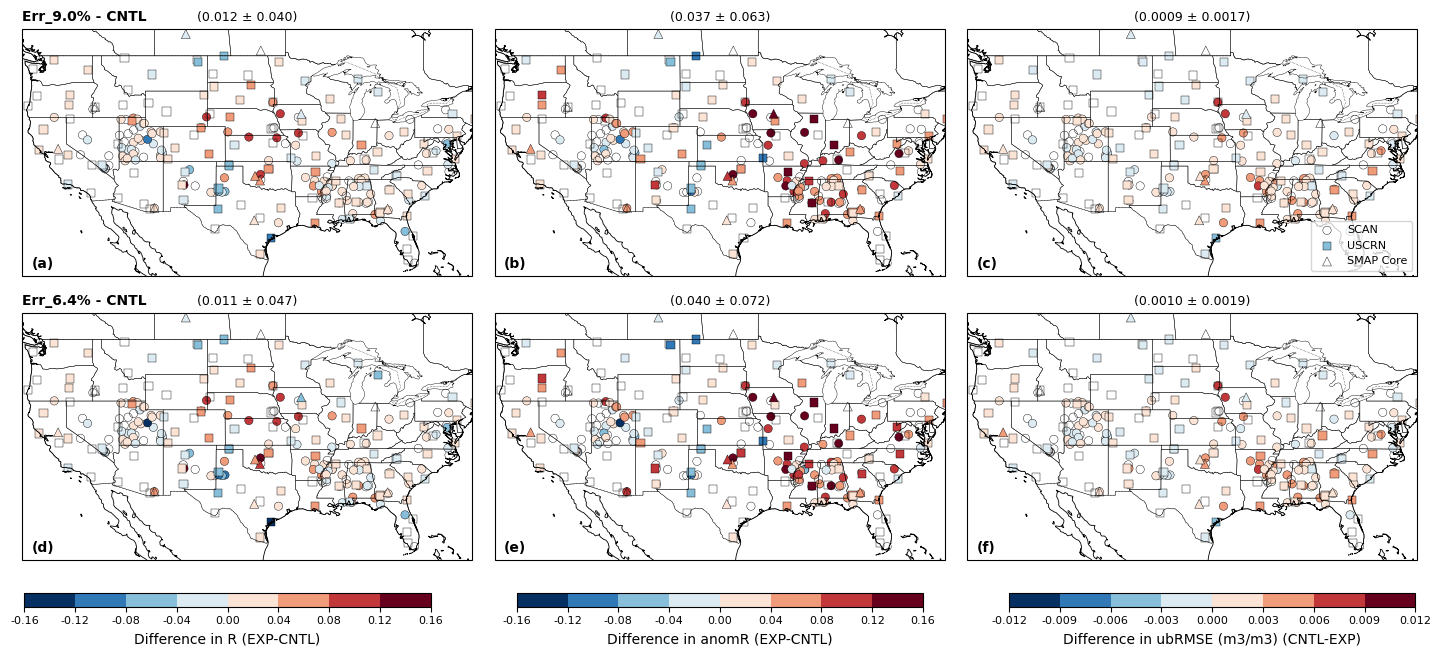

In [15]:
# Combined 3x3 overlay for all networks (SCAN, USCRN, SMAP Core) for ROOTZONE soil moisture
fig, axes = plt.subplots(2, 3, figsize=(18, 7), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.reshape(2, 3)
lab_idx = 0
legend_handles = None
legend_labels = None

# Store all data for statistics calculation
panel_stats_rz = {}

for r_idx, (row_title, exp_idx) in enumerate(rows):
    for c_idx, (metric, levels, cmap) in enumerate(zip(['R', 'anomR', 'ubRMSE'], levels_list, cmaps)):
        ax = axes[r_idx, c_idx]
        norm = BoundaryNorm(levels, cmap.N)
        
        # Collect all data points for this panel
        all_data = []
        
        for tag, nlabel, marker, size in overlay_networks:
            arr = overlay_data[tag][metric]
            if metric == 'ubRMSE':
                # Use rootzone (depth=1) for ubRMSE
                data = arr[:, 1, 0] - arr[:, 1, exp_idx]
            else:
                # Use rootzone (depth=1) for R and anomR
                data = arr[:, 1, exp_idx] - arr[:, 1, 0]
            
            # Only include non-NaN values
            valid_data = data[~np.isnan(data)]
            all_data.extend(valid_data)
            
            lat = overlay_data[tag]['lat']
            lon = overlay_data[tag]['lon']
            sc = ax.scatter(lon, lat, c=data, cmap=cmap, norm=norm, s=size,
                            marker=marker, edgecolor='k', linewidths=0.3,
                            transform=ccrs.PlateCarree(), label=nlabel)
        
        # Calculate statistics for this panel
        if all_data:
            panel_mean = np.mean(all_data)
            panel_std = np.std(all_data)
            panel_stats_rz[(r_idx, c_idx)] = (panel_mean, panel_std)
        else:
            panel_stats_rz[(r_idx, c_idx)] = (np.nan, np.nan)
        
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=':')
        ax.add_feature(cfeature.STATES, linewidth=0.3)
        ax.set_extent([-125, -74, 24, 52], crs=ccrs.PlateCarree())
        ax.set_title(row_title if c_idx == 0 else '', fontsize=10, loc='left', fontweight='bold')
        ax.tick_params(labelbottom=False, labelleft=False)
        ax.text(0.02, 0.02, labels[lab_idx], transform=ax.transAxes,
                fontsize=10, fontweight='bold', va='bottom', ha='left')
        
        # Add statistics text above the panel
        mean_val, std_val = panel_stats_rz[(r_idx, c_idx)]
        if not np.isnan(mean_val):
            if metric == 'ubRMSE':
                stats_text = f'({mean_val:.4f} ± {std_val:.4f})'
            else:
                stats_text = f'({mean_val:.3f} ± {std_val:.3f})'
        else:
            stats_text = 'μ=NaN, σ=NaN'
        
        ax.text(0.5, 1.02, stats_text, transform=ax.transAxes,
                fontsize=9, ha='center', va='bottom')
        
        if legend_handles is None:
            legend_handles, legend_labels = ax.get_legend_handles_labels()
        lab_idx += 1

# Add a single legend
if legend_handles:
    axes[0,2].legend(legend_handles, legend_labels, loc='lower right', fontsize=8, frameon=True)

# Colorbars under each column
cbar_h = 0.02
bottom_row = axes[-1, :]
y_min = min(ax.get_position().y0 for ax in bottom_row)
gap = 0.02
cbar_y = y_min - gap - cbar_h
for levels, cmap, title, col_ax in zip(levels_list, cmaps, titles_col, axes.T):
    x0 = min(ax.get_position().x0 for ax in col_ax)
    x1 = max(ax.get_position().x1 for ax in col_ax)
    span = x1 - x0
    width = 0.99 * span
    xpos = x0 + 0.5 * (span - width)
    norm = BoundaryNorm(levels, cmap.N)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = fig.add_axes([xpos, cbar_y, width, cbar_h])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label(title, fontsize=10)
    cbar.set_ticks(levels)
    if title.startswith('Difference in ubRMSE'):
        cbar.ax.set_xticklabels([f"{lvl:.3f}" for lvl in levels], fontsize=8)
    else:
        cbar.ax.set_xticklabels([f"{lvl:.2f}" for lvl in levels], fontsize=8)

plt.subplots_adjust(wspace=0.05, hspace=0.08, bottom=0.14, top=0.92)
plt.show()